# 04.4 Good Controls vs Bad Controls: A Decision Framework

**Chapter**: 4 - Graphical Causal Models  
**Section**: 4 - Good/Bad Controls  
**Facure Source**: 04-Graphical-Causal-Models.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [The Control Variable Paradox](#11-the-control-variable-paradox)
   - 1.2 [The Decision Rule](#12-the-decision-rule)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Good Controls](#21-good-controls)
   - 2.2 [Bad Controls](#22-bad-controls)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Decision Tree in Action](#31-decision-tree-in-action)
   - 3.2 [Common Mistakes](#32-common-mistakes)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm,
    set_notebook_style,
    create_tufte_figure,
    TUFTE_PALETTE,
)

set_notebook_style()
np.random.seed(42)

---

## 1. Facure's Intuition

> **Interview Relevance**: "What variables should I control for?" is the most common question in causal inference. The answer is NOT "everything you can measure."

### 1.1 The Control Variable Paradox

Facure's key warning:

> "Selection bias can often be fixed by simply doing nothing, which is why it is dangerous. Since we are biased toward action, we tend to see ideas that control things as clever when they can be doing more harm than good."

**The temptation**: "Let's add more controls to be safe."

**The reality**: Some controls introduce bias, not remove it.

### 1.2 The Decision Rule

| Variable Type | Control? | Reason |
|--------------|----------|--------|
| **Confounder** | ✅ YES | Blocks backdoor path |
| **Collider** | ❌ NO | Opens spurious path |
| **Mediator** | ❌ (for total effect) | Blocks causal path |
| **Instrument** | ❌ NO | Reduces variation in T |
| **Outcome predictor** | ✅ YES | Reduces variance (bonus) |

★ Insight ─────────────────────────────────────
- Draw your DAG BEFORE choosing controls
- Not controlling can be the right choice
- "Kitchen sink" regression is dangerous
- Pre-treatment variables are generally safe; post-treatment are risky
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Good Controls

**Confounders** (must control):
- Common causes of T and Y
- DAG: X → T, X → Y
- Blocking backdoor path is essential

**Outcome predictors** (optional, helpful):
- Variables that predict Y but NOT T
- DAG: W → Y (no connection to T)
- Reduces residual variance → more precise estimates

**Surrogate confounders** (when confounder unmeasured):
- Variables caused by the unmeasured confounder
- Partial absorption of confounding bias

### 2.2 Bad Controls

**Colliders** (creates bias):
- Common effects of T and Y
- DAG: T → C ← Y
- Conditioning opens spurious path

**Mediators** (blocks causal path):
- On the causal path T → M → Y
- Conditioning removes indirect effect
- Only control if you want direct effect specifically

**Descendants of colliders**:
- Variables caused by colliders
- Conditioning partially opens the collider path

**Instruments** (reduces efficiency):
- Variables that affect T but not Y directly
- DAG: Z → T
- Controlling removes useful variation in T

---

## 3. Numeric Demonstration

### 3.1 Decision Tree in Action

In [2]:
# Comprehensive simulation with all variable types
np.random.seed(42)
n = 5000

TRUE_EFFECT = 5.0

# ===== GOOD CONTROLS =====
# Confounder: affects both T and Y
confounder = np.random.normal(0, 1, n)

# Outcome predictor: affects Y only
outcome_predictor = np.random.normal(0, 1, n)

# ===== BAD CONTROLS =====
# Treatment: affected by confounder
treatment = 0.5 * confounder + np.random.normal(0, 1, n)

# Mediator: caused by treatment, affects outcome
mediator = 0.5 * treatment + np.random.normal(0, 0.5, n)

# Outcome: affected by treatment (direct + via mediator) + confounder + predictor
outcome = (TRUE_EFFECT * treatment + 
           3 * mediator +  # Indirect effect through mediator
           2 * confounder + 
           1.5 * outcome_predictor + 
           np.random.normal(0, 2, n))

# Collider: caused by BOTH treatment and outcome
collider = 0.3 * treatment + 0.3 * outcome + np.random.normal(0, 1, n)

# Descendant of collider
collider_descendant = 0.5 * collider + np.random.normal(0, 0.5, n)

df = pd.DataFrame({
    'treatment': treatment,
    'outcome': outcome,
    'confounder': confounder,
    'outcome_predictor': outcome_predictor,
    'mediator': mediator,
    'collider': collider,
    'collider_descendant': collider_descendant,
})

print("COMPREHENSIVE CONTROL VARIABLE SIMULATION")
print("="*60)
print(f"True total effect: {TRUE_EFFECT + 3*0.5:.1f} (direct + indirect via mediator)")
print(f"True direct effect: {TRUE_EFFECT:.1f}")

COMPREHENSIVE CONTROL VARIABLE SIMULATION
True total effect: 6.5 (direct + indirect via mediator)
True direct effect: 5.0


In [3]:
# Test different control strategies
results = []

# 1. No controls (biased by confounding)
m1 = sm.OLS(df['outcome'], sm.add_constant(df['treatment'])).fit()
results.append(('No controls', m1.params['treatment'], 'BIASED (confounding)'))

# 2. Control for confounder only (CORRECT for total effect)
m2 = sm.OLS(df['outcome'], sm.add_constant(df[['treatment', 'confounder']])).fit()
results.append(('+ Confounder', m2.params['treatment'], 'CORRECT (total effect)'))

# 3. Add outcome predictor (more precise)
m3 = sm.OLS(df['outcome'], sm.add_constant(df[['treatment', 'confounder', 'outcome_predictor']])).fit()
results.append(('+ Outcome predictor', m3.params['treatment'], 'CORRECT + more precise'))

# 4. Control for mediator (gives direct effect only)
m4 = sm.OLS(df['outcome'], sm.add_constant(df[['treatment', 'confounder', 'mediator']])).fit()
results.append(('+ Mediator', m4.params['treatment'], 'Direct effect only'))

# 5. Control for collider (BAD!)
m5 = sm.OLS(df['outcome'], sm.add_constant(df[['treatment', 'confounder', 'collider']])).fit()
results.append(('+ Collider', m5.params['treatment'], 'BIASED (collider opened)'))

# 6. Control for collider descendant (also BAD)
m6 = sm.OLS(df['outcome'], sm.add_constant(df[['treatment', 'confounder', 'collider_descendant']])).fit()
results.append(('+ Collider descendant', m6.params['treatment'], 'BIASED (collider partially opened)'))

# 7. Kitchen sink (everything)
m7 = sm.OLS(df['outcome'], sm.add_constant(df[['treatment', 'confounder', 'outcome_predictor', 
                                                'mediator', 'collider']])).fit()
results.append(('Kitchen sink', m7.params['treatment'], 'MULTIPLY BIASED'))

print("CONTROL VARIABLE COMPARISON")
print("="*70)
print(f"True total effect: {TRUE_EFFECT + 3*0.5:.1f}")
print(f"True direct effect: {TRUE_EFFECT:.1f}")
print("-"*70)
print(f"{'Controls':<25} {'Estimate':>10} {'Assessment':<30}")
print("-"*70)
for name, est, assessment in results:
    print(f"{name:<25} {est:>10.2f} {assessment:<30}")

CONTROL VARIABLE COMPARISON
True total effect: 6.5
True direct effect: 5.0
----------------------------------------------------------------------
Controls                    Estimate Assessment                    
----------------------------------------------------------------------
No controls                     7.35 BIASED (confounding)          
+ Confounder                    6.55 CORRECT (total effect)        
+ Outcome predictor             6.56 CORRECT + more precise        
+ Mediator                      5.12 Direct effect only            
+ Collider                      3.37 BIASED (collider opened)      
+ Collider descendant           4.55 BIASED (collider partially opened)
Kitchen sink                    3.59 MULTIPLY BIASED               


### 3.2 Common Mistakes

In [4]:
# Visualize the decision tree
print("CONTROL VARIABLE DECISION TREE")
print("="*70)
print("""
For each candidate control variable X, ask:

1. Is X affected by Treatment (T)?
   │
   ├── YES → Is X on the causal path to Y?
   │         │
   │         ├── YES → X is a MEDIATOR
   │         │         → Do NOT control (for total effect)
   │         │         → Control only if you want direct effect
   │         │
   │         └── NO → Is X also affected by Y?
   │                  │
   │                  ├── YES → X is a COLLIDER
   │                  │         → Do NOT control!
   │                  │
   │                  └── NO → X is a descendant of T
   │                           → Generally do NOT control
   │
   └── NO → Does X affect both T and Y?
            │
            ├── YES → X is a CONFOUNDER
            │         → MUST control
            │
            └── NO → Does X affect only Y?
                     │
                     ├── YES → X is an OUTCOME PREDICTOR
                     │         → Control (improves precision)
                     │
                     └── NO → Does X affect only T?
                              │
                              ├── YES → X is an INSTRUMENT
                              │         → Do NOT control
                              │
                              └── NO → X is unrelated
                                       → No need to control
""")

CONTROL VARIABLE DECISION TREE

For each candidate control variable X, ask:

1. Is X affected by Treatment (T)?
   │
   ├── YES → Is X on the causal path to Y?
   │         │
   │         ├── YES → X is a MEDIATOR
   │         │         → Do NOT control (for total effect)
   │         │         → Control only if you want direct effect
   │         │
   │         └── NO → Is X also affected by Y?
   │                  │
   │                  ├── YES → X is a COLLIDER
   │                  │         → Do NOT control!
   │                  │
   │                  └── NO → X is a descendant of T
   │                           → Generally do NOT control
   │
   └── NO → Does X affect both T and Y?
            │
            ├── YES → X is a CONFOUNDER
            │         → MUST control
            │
            └── NO → Does X affect only Y?
                     │
                     ├── YES → X is an OUTCOME PREDICTOR
                     │         → Control (improves precision)
        

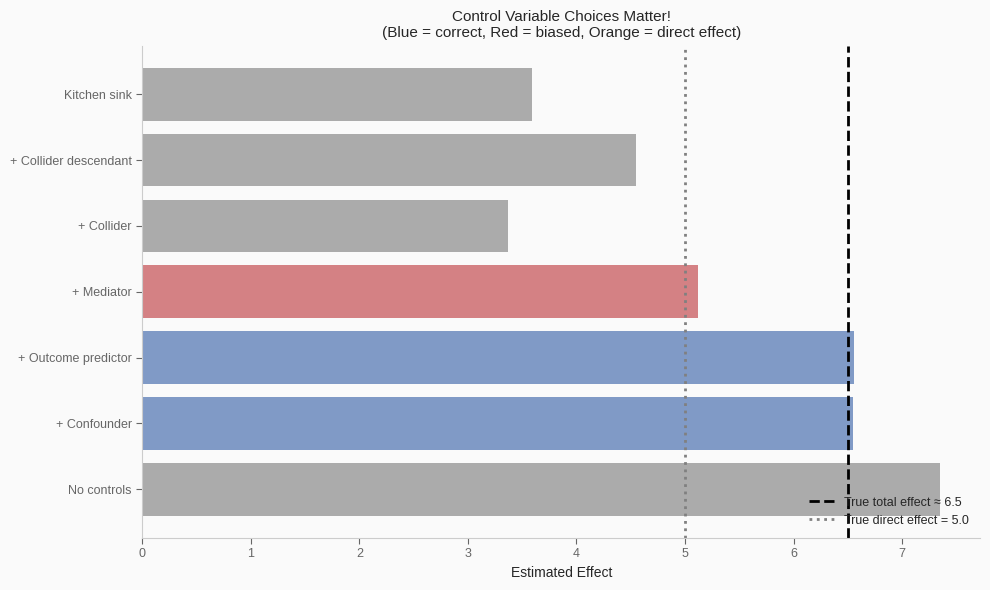

In [5]:
# Summary visualization
fig, ax = create_tufte_figure(1, 1, figsize=(10, 6))

estimates = [r[1] for r in results]
names = [r[0] for r in results]
colors = [
    TUFTE_PALETTE['control'],      # No controls (biased)
    TUFTE_PALETTE['treatment'],    # Confounder (correct)
    TUFTE_PALETTE['treatment'],    # + Predictor (correct)
    TUFTE_PALETTE['effect'],       # Mediator (direct only)
    TUFTE_PALETTE['control'],      # Collider (biased)
    TUFTE_PALETTE['control'],      # Collider desc (biased)
    TUFTE_PALETTE['control'],      # Kitchen sink (biased)
]

bars = ax.barh(range(len(names)), estimates, color=colors, alpha=0.7)
ax.axvline(TRUE_EFFECT + 1.5, color='black', linestyle='--', linewidth=2, 
           label=f'True total effect ≈ {TRUE_EFFECT + 1.5:.1f}')
ax.axvline(TRUE_EFFECT, color='gray', linestyle=':', linewidth=2,
           label=f'True direct effect = {TRUE_EFFECT:.1f}')

ax.set_yticks(range(len(names)))
ax.set_yticklabels(names)
ax.set_xlabel('Estimated Effect')
ax.set_title('Control Variable Choices Matter!\n(Blue = correct, Red = biased, Orange = direct effect)')
ax.legend(frameon=False, loc='lower right')

plt.tight_layout()
plt.show()

---

## 4. Implementation

```python
# STEP 1: Draw your DAG
# Identify: T (treatment), Y (outcome)
# Classify each candidate control

# STEP 2: Identify confounders
confounders = ['age', 'income', 'education']  # Common causes

# STEP 3: Identify outcome predictors (optional precision boost)
predictors = ['prior_outcome']  # Predict Y but don't affect T

# STEP 4: Identify variables to EXCLUDE
bad_controls = ['post_treatment_status',  # Mediator
                'combined_metric',        # Likely collider
                'downstream_outcome']     # Descendant

# STEP 5: Build model with GOOD controls only
good_controls = confounders + predictors
X = sm.add_constant(df[['treatment'] + good_controls])
model = sm.OLS(df['outcome'], X).fit()

# STEP 6: Check results
print(model.summary())
```

**The Rule**: When in doubt, draw the DAG. If you can't draw the DAG, you don't understand the problem well enough to choose controls.

---

## 5. Interview Appendix

**Q1 (Any Company)**: *"How do you decide which variables to control for in a regression?"*

<details><summary>Solution</summary>

**Framework**:

1. **Draw a DAG** showing hypothesized causal relationships

2. **Control for**:
   - **Confounders**: Common causes of treatment and outcome
   - **Outcome predictors**: Variables that predict Y but don't affect T (precision boost)

3. **Do NOT control for**:
   - **Colliders**: Common effects of T and Y
   - **Mediators**: Variables on the causal path (unless you want direct effect)
   - **Post-treatment variables**: Generally risky

4. **Use the backdoor criterion**: Control set must block all backdoor paths without opening new ones

**Key insight**: "More controls" is not always better. Drawing the DAG first prevents mistakes.

</details>

**Q2 (Meta, Google)**: *"Why is 'kitchen sink' regression (controlling for everything) a bad idea?"*

<details><summary>Solution</summary>

**Problems with kitchen sink**:

1. **Collider bias**: Including common effects of T and Y creates spurious associations

2. **Mediator bias**: Including variables on the causal path blocks the indirect effect

3. **Post-treatment bias**: Variables affected by T can introduce selection bias

4. **Multicollinearity**: Many correlated controls inflate standard errors

5. **Overfitting**: Too many controls relative to sample size

**The alternative**: Theory-driven selection based on DAG
- Identify what needs to be controlled (confounders)
- Identify what should NOT be controlled (colliders, mediators)
- Be explicit about assumptions

</details>

**Q3 (Stripe, Airbnb)**: *"Your model has a post-treatment control variable. When is this okay, and when is it problematic?"*

<details><summary>Solution</summary>

**When post-treatment controls are problematic**:

1. **Mediators**: If T → M → Y, controlling for M removes indirect effect
   - Only control if you specifically want direct effect

2. **Colliders**: If T → C ← Y, controlling creates bias
   - Never control for colliders

3. **Confounded mediators**: If T → M → Y and U → M, U → Y
   - Controlling for M opens backdoor through U

**When post-treatment controls might be okay**:

1. **Variables affected by T but not affecting Y**
   - Rare in practice

2. **Mediation analysis** (explicitly decomposing effects)
   - Use proper mediation methods, not naive regression

**Rule of thumb**: Pre-treatment variables are generally safe; post-treatment variables require careful DAG analysis.

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 4.

[^2]: Cinelli, C., Forney, A., & Pearl, J. (2020). A crash course in good and bad controls. Working paper.

[^3]: Angrist, J. D., & Pischke, J.-S. (2009). *Mostly Harmless Econometrics*. Princeton University Press, Chapter 3.

[^4]: Huntington-Klein, N. (2022). *The Effect: An Introduction to Research Design and Causality*. CRC Press, Chapter 8.